<a href="https://colab.research.google.com/github/vit050587/ML_in_work/blob/master/HW2_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Подготовка кода для ДЗ

In [ ]:
import pandas as pd

In [ ]:
news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML_in_work/Lection2/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [ ]:
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML_in_work/Lection2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [ ]:
!pip install gensim
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.1 MB/s 
     |████████████████████████████████| 2.2 MB 54.3 MB/s 


In [ ]:
from gensim.corpora.dictionary import Dictionary

In [ ]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 6.6 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=3b0bf49dcf10242d7275445d1bd846ce25d8d7e3796190890853b593094ed835
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [ ]:
#предобработка текстов
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel


import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/ML_in_work/Lection2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 27.8 s, sys: 1.34 s, total: 29.1 s
Wall time: 30 s


In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 9s, sys: 696 ms, total: 4min 10s
Wall time: 4min 11s


In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [ ]:
common_dictionary[10]

'ватутин'

In [ ]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim.models import LdaModel

In [ ]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 54.3 s, sys: 26.5 s, total: 1min 20s
Wall time: 60 s


In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [ ]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(7, 0.10062669),
 (9, 0.3506506),
 (10, 0.050084043),
 (11, 0.21378927),
 (12, 0.2273463),
 (20, 0.03896649)]

In [ ]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: фонд животное вода научный ветер день производитель
topic_1: снижение смерть nn мкс затмение лунный астронавт
topic_2: ракета космический орбита корабль полёт первый аппарат
topic_3: nn луна путин белоруссия россия венесуэла пресссекретарить
topic_4: военный погибнуть операция самолёт китай пенсия россия
topic_5: млрд эксперт экономика научный средство россия российский
topic_6: школа всё ребёнок общество работник астроном способность
topic_7: население наука исследование всё рак первый уровень
topic_8: млн банк рост тыс цена рубль составить
topic_9: ск зуб употребление железный днк остановка донбасс
topic_10: мозг снижение диапазон грант канал nn частица
topic_11: всё очень хороший большой nn риск мозг
topic_12: учёный обнаружить взрыв произойти останки свет установить
topic_13: учёный писать тело самолёт турист спутник день
topic_14: россия российский сша нефть сторона санкция технология
topic_15: россия новый рынок проект система развитие доля
topic_16: россия вопрос решени

In [ ]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.19383,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.057265,0.569013,0.0,0.0,0.0,0.092606,0.0,0.000000,0.000000,0.0
1,4896,0.00000,0.0,0.0,0.132081,0.042314,0.0,0.0,0.00000,0.0,...,0.000000,0.086320,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,4897,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.10046,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.038959,0.0,0.000000,0.000000,0.0
3,4898,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.454753,0.000000,0.0
4,4899,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.778159,0.0,0.0,0.0,0.000000,0.0,0.000000,0.046268,0.0


### Следующий шаг - векторные представления пользователей

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [ ]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding(user_articles_list)

array([0.        , 0.0041837 , 0.00768773, 0.08747968, 0.05532315,
       0.06545586, 0.        , 0.04182881, 0.00623669, 0.        ,
       0.        , 0.0174193 , 0.00871231, 0.07507222, 0.08492733,
       0.03688859, 0.25857591, 0.07288663, 0.00950955, 0.        ,
       0.01061396, 0.01362222, 0.03776531, 0.        , 0.09319798])

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.027063,0.007793,0.012275,0.006831,0.012309,0.018759,0.018746,0.053394,...,0.012633,0.071516,0.051943,0.113508,0.012085,0.019725,0.058716,0.108104,0.042322,0.131552
1,u108690,0.004987,0.004634,0.000000,0.027299,0.000000,0.034883,0.002049,0.078105,0.021108,...,0.018350,0.114281,0.084231,0.027861,0.032579,0.000000,0.005599,0.026075,0.077056,0.141649
2,u108339,0.022080,0.000000,0.000000,0.091231,0.031364,0.063453,0.010636,0.032214,0.000000,...,0.005633,0.176313,0.037020,0.032732,0.028187,0.012622,0.006386,0.089397,0.000000,0.129919


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML_in_work/Lection2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.027063,0.007793,0.012275,0.006831,0.012309,0.018759,0.018746,0.053394,...,0.071516,0.051943,0.113508,0.012085,0.019725,0.058716,0.108104,0.042322,0.131552,0
1,u108690,0.004987,0.004634,0.000000,0.027299,0.000000,0.034883,0.002049,0.078105,0.021108,...,0.114281,0.084231,0.027861,0.032579,0.000000,0.005599,0.026075,0.077056,0.141649,1
2,u108339,0.022080,0.000000,0.000000,0.091231,0.031364,0.063453,0.010636,0.032214,0.000000,...,0.176313,0.037020,0.032732,0.028187,0.012622,0.006386,0.089397,0.000000,0.129919,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06955359, 0.0715261 , 0.37311962, 0.17940152, 0.18307026,
       0.1148424 , 0.08561213, 0.01300697, 0.10026657, 0.10452537])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.265884, F-Score=0.660, Precision=0.643, Recall=0.678


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1663   92]
 [  80  165]]


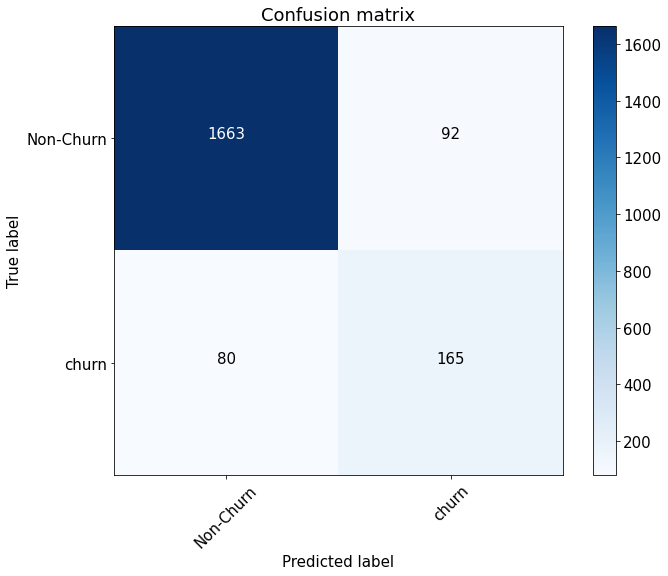

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test, preds)

0.9332496075353218

**Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)**

In [ ]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.01093961, 0.        ,
       0.03280388, 0.        , 0.01874031, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05166299, 0.04097584,
       0.0377539 , 0.1418809 , 0.03389174, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01103444])

In [ ]:
user_embeddings1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings1['uid'] = users['uid'].values
user_embeddings1 = user_embeddings1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.031727,0.026723,0.101618,0.000000,0.0,0.018837,0.042375,0.000000,0.067272
1,u108690,0.000000,0.0,0.0,0.030009,0.000000,0.015959,0.000000,0.061040,0.0,...,0.008791,0.103752,0.042947,0.000000,0.010009,0.0,0.000000,0.014532,0.020832,0.143103
2,u108339,0.017892,0.0,0.0,0.012134,0.031109,0.055499,0.009114,0.037597,0.0,...,0.000000,0.204288,0.040663,0.000000,0.019368,0.0,0.000000,0.060076,0.000000,0.138096


In [ ]:
X1 = pd.merge(user_embeddings1, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.031727,0.026723,0.101618,0.000000,0.0,0.018837,0.042375,0.000000,0.067272,0
1,u108690,0.000000,0.0,0.0,0.030009,0.000000,0.015959,0.000000,0.061040,0.0,...,0.103752,0.042947,0.000000,0.010009,0.0,0.000000,0.014532,0.020832,0.143103,1
2,u108339,0.017892,0.0,0.0,0.012134,0.031109,0.055499,0.009114,0.037597,0.0,...,0.204288,0.040663,0.000000,0.019368,0.0,0.000000,0.060076,0.000000,0.138096,1


In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

In [ ]:
logreg1 = LogisticRegression()
#обучим 
logreg1.fit(X_train1, y_train1)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds1 = logreg1.predict_proba(X_test1)[:, 1]
preds1[:10]

array([0.14065498, 0.03860947, 0.40173618, 0.25699584, 0.1735541 ,
       0.10617352, 0.15739773, 0.01649061, 0.07666735, 0.14360537])

Перед расчетом метрик подготовим базу для таблицы сравнения метрик:

In [ ]:
metric_list=[[i] for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix]]]
metric_list

[[0.2658841094924936],
 [0.6600397614314116],
 [0.6434108527131783],
 [0.6775510204081633]]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test1, preds1)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.269510, F-Score=0.677, Precision=0.650, Recall=0.706


In [ ]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.2658841094924936, 0.26950960174460087],
 [0.6600397614314116, 0.6771037181996087],
 [0.6434108527131783, 0.650375939849624],
 [0.6775510204081633, 0.7061224489795919]]

Confusion matrix, without normalization
[[1662   93]
 [  73  172]]


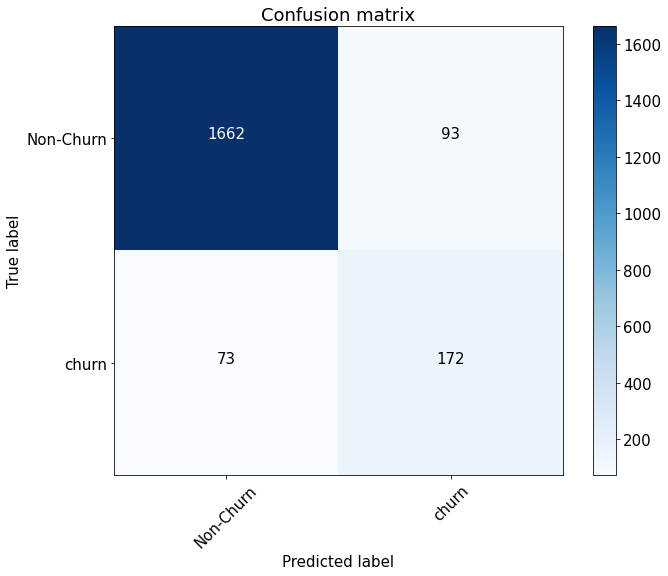

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test1, preds1>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test1, preds1)

0.9523902552473981

**Повторим п.2, но используя уже не медиану, а max**

In [ ]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.02510219, 0.04612641, 0.4318417 , 0.16856089,
       0.17388491, 0.        , 0.12787923, 0.03742016, 0.        ,
       0.        , 0.0704075 , 0.05227387, 0.20372458, 0.26742554,
       0.07181989, 0.83909059, 0.20891695, 0.05705727, 0.        ,
       0.06368377, 0.06064396, 0.22659184, 0.        , 0.43527377])

In [ ]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.162376,0.046756,0.073649,0.040984,0.040023,0.077744,0.100792,0.228576,...,0.057160,0.209995,0.130642,0.275286,0.052811,0.086829,0.254463,0.309604,0.253933,0.383880
1,u108690,0.016871,0.016925,0.000000,0.053056,0.000000,0.092681,0.012292,0.188486,0.099667,...,0.050956,0.228981,0.320335,0.136719,0.141553,0.000000,0.033592,0.072623,0.236024,0.304172
2,u108339,0.053658,0.000000,0.000000,0.319108,0.067334,0.145312,0.026569,0.067840,0.000000,...,0.033799,0.331346,0.059402,0.196393,0.085702,0.053918,0.020370,0.300861,0.000000,0.247708


In [ ]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.162376,0.046756,0.073649,0.040984,0.040023,0.077744,0.100792,0.228576,...,0.209995,0.130642,0.275286,0.052811,0.086829,0.254463,0.309604,0.253933,0.383880,0
1,u108690,0.016871,0.016925,0.000000,0.053056,0.000000,0.092681,0.012292,0.188486,0.099667,...,0.228981,0.320335,0.136719,0.141553,0.000000,0.033592,0.072623,0.236024,0.304172,1
2,u108339,0.053658,0.000000,0.000000,0.319108,0.067334,0.145312,0.026569,0.067840,0.000000,...,0.331346,0.059402,0.196393,0.085702,0.053918,0.020370,0.300861,0.000000,0.247708,1


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [ ]:
logreg2 = LogisticRegression()
#обучим 
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.0083572 , 0.08070981, 0.55718281, 0.12753182, 0.0366338 ,
       0.03977229, 0.08877292, 0.01251055, 0.07550292, 0.19973002])

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.341749, F-Score=0.745, Precision=0.732, Recall=0.759


In [ ]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.2658841094924936, 0.26950960174460087, 0.34174876995688924],
 [0.6600397614314116, 0.6771037181996087, 0.7454909819639279],
 [0.6434108527131783, 0.650375939849624, 0.7322834645669292],
 [0.6775510204081633, 0.7061224489795919, 0.7591836734693878]]

Confusion matrix, without normalization
[[1687   68]
 [  60  185]]


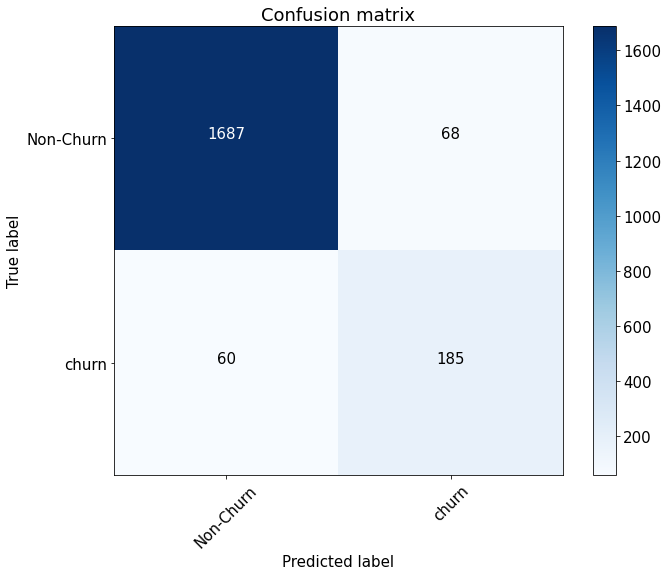

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test2, preds2)

0.9634536891679749

**Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score**

In [ ]:
metric_df=pd.DataFrame(
    metric_list, columns=['mean','median','max'], index=['Treshhold','F-score','Precision', 'Recall']
).append(pd.DataFrame(
                    [[roc_auc_score(y_test, preds),roc_auc_score(y_test1, preds1),roc_auc_score(y_test2, preds2)]],
    columns=['mean','median','max'],
    index=['ROC-AUC']))
metric_df

,mean,median,max
Treshhold,0.265884,0.269510,0.341749
F-score,0.660040,0.677104,0.745491
Precision,0.643411,0.650376,0.732283
Recall,0.677551,0.706122,0.759184
ROC-AUC,0.933250,0.952390,0.963454


**Вывод: Как видно из таблицы, наиболее эффективным оказался метод с использованием медианы для получения эмбеддинга пользователя, т.к. мы получаем более разреженный вектор заинтересованности пользователя, в следствии того, что что в отличии от среднего и максимального значения, медиана чаще будет равна нулю, на тех темах статей, оторые редко появляются в векторе статей читаемых пользователем. То есть интересы пользователя будут выражены наиболее явно.**